In [ ]:
import cuqi
import numpy as np
import matplotlib.pyplot as plt
import deepinv as dinv
import torch
import scipy
import skimage as ski
from skimage.transform import resize

/Users/chaz/miniconda3/envs/deepinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("CUQI version:", cuqi.__version__)
print("DeepInv version:", dinv.__version__)

CUQI version: 1.3.0
DeepInv version: 0.3


## Load `x_true`

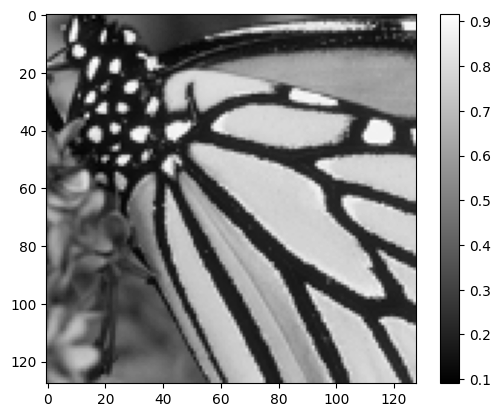

In [ ]:
image = resize(ski.util.img_as_float(ski.io.imread("05.png"))[56:,56:], (128,128))
x_true = image.flatten()
dim = image.shape[0]

In [4]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

True image shape: (16384,)


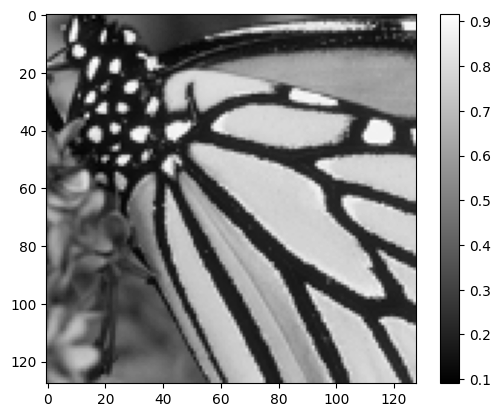

In [5]:
plt.imshow(x_true.reshape(dim,dim), cmap="gray")
plt.colorbar()
print("True image shape:", x_true.shape)

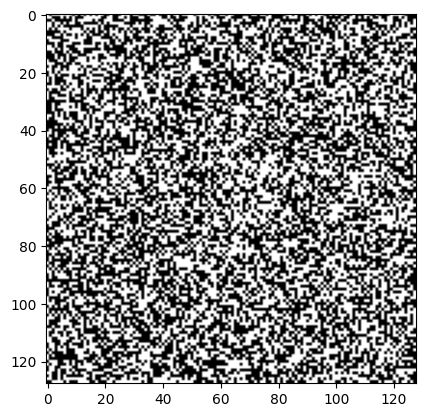

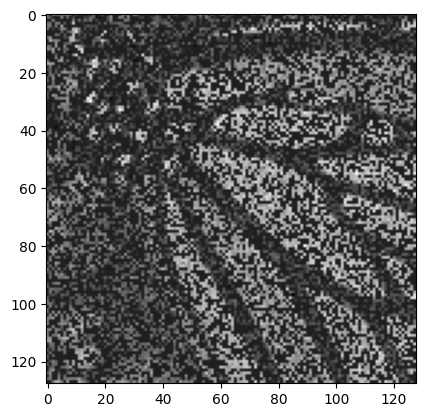

In [ ]:
# define forward operator and create data
np.random.seed(1)
zero_density = 0.5# we keep 70% of the pixels
mask_vector = np.random.random(size=dim**2) < zero_density
# convert mask_vector to a vector of 0s and 1s
mask_vector = mask_vector.astype(int)
# mask = np.diag(mask_vector)
mask = scipy.sparse.diags(mask_vector)
y_exact = x_true @ mask

noise_std = 0.1 # half noise
y_obs = y_exact + np.random.normal(0, noise_std, size=y_exact.shape)@mask

plt.imshow(mask_vector.reshape(dim, dim), cmap='gray')
plt.figure()
plt.imshow(y_obs.reshape(dim, dim), cmap='gray')

# DnCNN denoiser prior

In [ ]:
sigma_denoiser = 2 / 255
denoiser=dinv.models.DnCNN(pretrained="download_lipschitz", in_channels=1, out_channels=1)

In [9]:
def nn_denoiser(x, restoration_strength=None):
    with torch.no_grad():
        result = denoiser.forward(torch.tensor(x.reshape(1,1,dim,dim), dtype=torch.float32), sigma=sigma_denoiser).detach().reshape(dim*dim).numpy()
    return result, None

In [10]:
restorator=cuqi.implicitprior.RestorationPrior(
    nn_denoiser,
    restorator_kwargs={},
    geometry=cuqi.geometry.Image2D((dim, dim), visual_only=True),
)

In [11]:
myprior = cuqi.implicitprior.MoreauYoshidaPrior(restorator, sigma_denoiser**2)

# Likelihood

In [12]:
# forward, likelihood
forward = cuqi.model.LinearModel(mask, domain_geometry=restorator.geometry, range_geometry=restorator.geometry)

prec = scipy.sparse.diags(np.ones(dim**2) / noise_std**2)  # sparse diagonal matrix
y = cuqi.distribution.Gaussian(forward@myprior, prec=prec)

# Posterior and sampling

In [ ]:
post = cuqi.distribution.JointDistribution(myprior, y)(y=y_obs)
step_size = 0.1*0.01 * (noise_std**2) * 2 # 2.5e-05 # is multiplied by 2 so be the same scaling as in deepinv ## note it is scaled by 0.1 now compared to deepinv
# x_initial = np.load("x_inital.npy").flatten()  # load a pre-defined initial guess
x_initial = y_obs.copy()
# sampler = cuqi.experimental.mcmc.PnPULA(post, scale=step_size, smoothing_strength=sigma_denoiser, initial_point=x_initial)
sampler = cuqi.experimental.mcmc.ULA(post, scale=step_size, initial_point=x_initial)
sampling_steps = 60000
warmup_steps = 40000
np.random.seed(0)  # for reproducibility
sampler.warmup(warmup_steps)
sampler.sample(sampling_steps)

Sample: 100%|██████████| 60000/60000 [1:13:40<00:00, 13.57it/s, acc rate: 100.00%]


Sampler: ULA 
 Target: 
 	 Posterior(
    Equation:
	 p(myprior|y) ∝ L(myprior|y)p(myprior)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['myprior'].
 	myprior ~ CUQI MoreauYoshidaPrior.
 ) 
 Current state: 
	 current_point: [0.44958894 0.46417156 0.46482729 ... 0.23257681 0.28177975 0.36788722] 
	 current_target_grad: [ 49.80298595 -68.62578329 -47.51584366 ... 100.49172308 -42.27360689
  24.82272364] 
	 scale: 2.0000000000000005e-05 

In [ ]:
thinning = 10  # thinning factor
samples = sampler.get_samples().burnthin(warmup_steps, thinning)

In [15]:
# samples = np.load("butterfly_samples_dncnn.npy", allow_pickle=True).item()

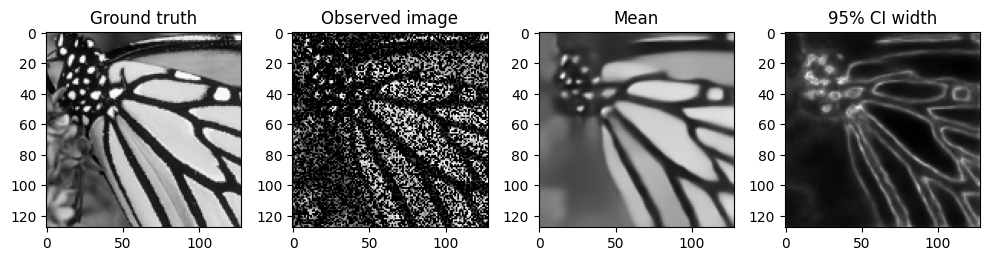

In [16]:
vmin = 0.1
vmax = 0.9
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
ax1.imshow(x_true.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title('Ground truth')
ax2.imshow(y_obs.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax2.set_title('Observed image')
ax3.imshow(samples.mean().reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax3.set_title('Mean')
ax4.imshow(samples.ci_width().reshape(dim, dim), cmap='gray')
ax4.set_title('95% CI width')
plt.tight_layout()
plt.savefig("comparision.pdf")

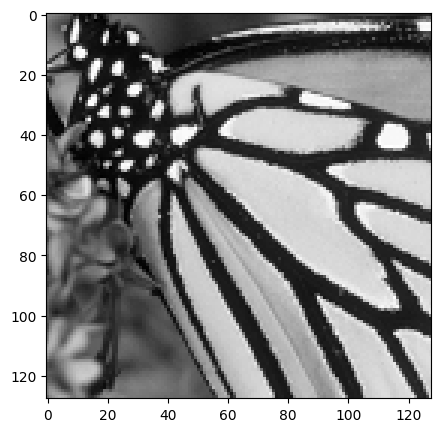

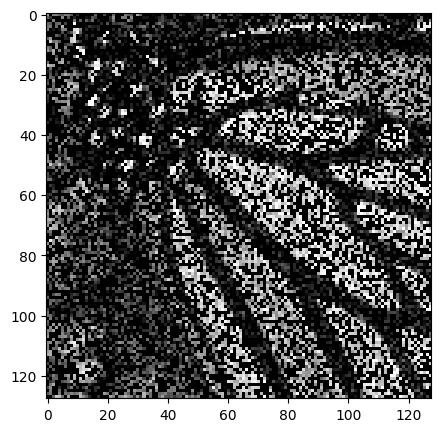

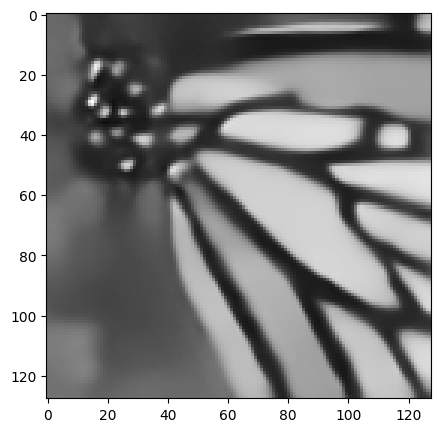

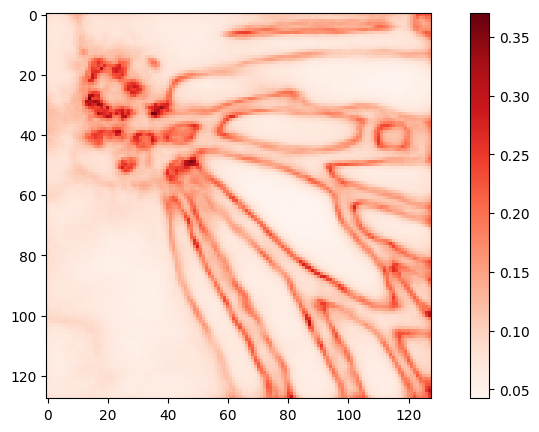

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(x_true.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
plt.savefig("groundtruth.pdf", bbox_inches='tight')
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(y_obs.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
plt.savefig("data.pdf", bbox_inches='tight')
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(samples.mean().reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
plt.savefig("mean_dncnn.pdf", bbox_inches='tight')
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(samples.ci_width().reshape(dim, dim), cmap='Reds')
plt.colorbar(im)
plt.savefig("ci_width_dncnn.pdf", bbox_inches='tight')

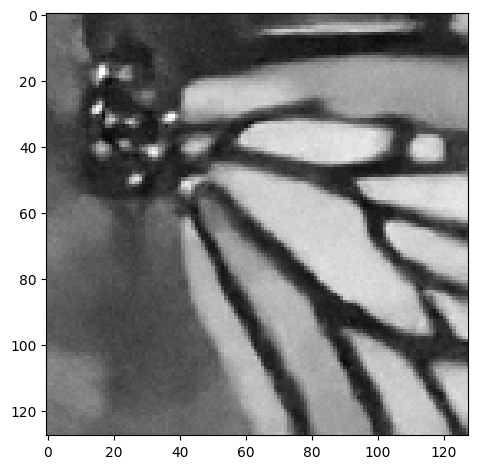

In [18]:
samples.plot(-1, vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.savefig("one_sample.pdf")

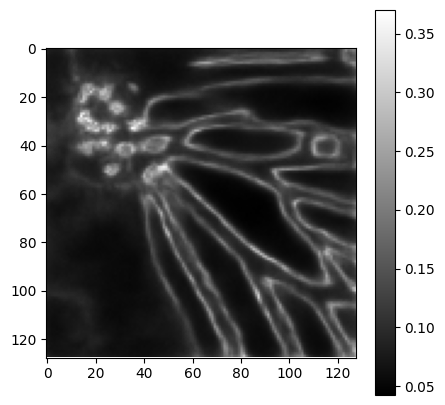

In [19]:
samples.plot_ci_width(cmap='gray')
# get fig of the last plot
plt.gcf().set_size_inches(5,5)
plt.title("")
plt.colorbar()
plt.savefig("ci_width.pdf")

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'v1224'}>,
        <Axes: title={'center': 'v1224'}>],
       [<Axes: title={'center': 'v3090'}>,
        <Axes: title={'center': 'v3090'}>],
       [<Axes: title={'center': 'v5060'}>,
        <Axes: title={'center': 'v5060'}>],
       [<Axes: title={'center': 'v13432'}>,
        <Axes: title={'center': 'v13432'}>],
       [<Axes: title={'center': 'v14919'}>,
        <Axes: title={'center': 'v14919'}>]], dtype=object)

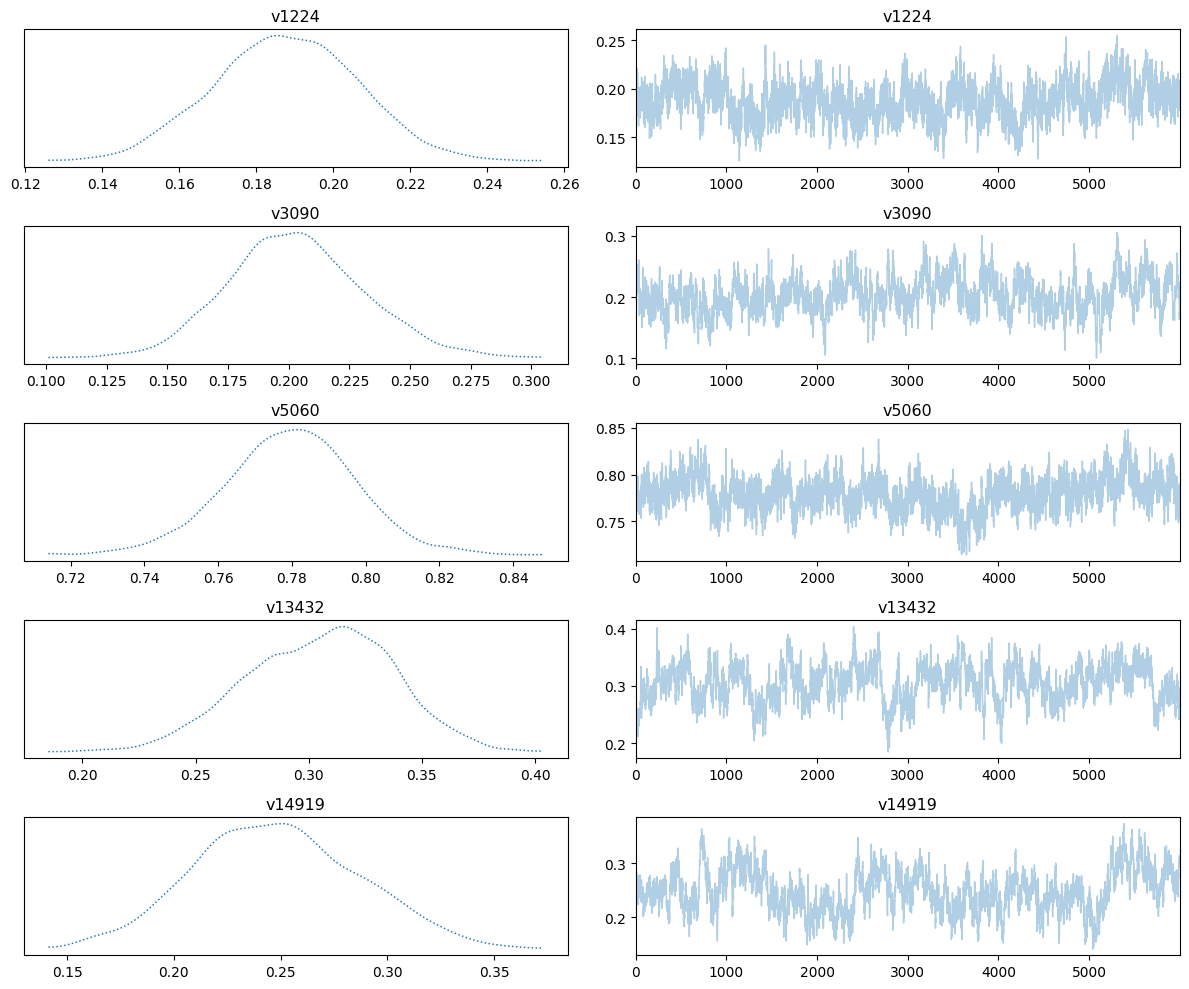

In [20]:
samples.plot_trace()

In [ ]:
# np.save("butterfly_samples_dncnn.npy", samples)